In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from enum import Enum
import os

from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import keras
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import tensorflow as tf

import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(45, 4)
(17, 4)


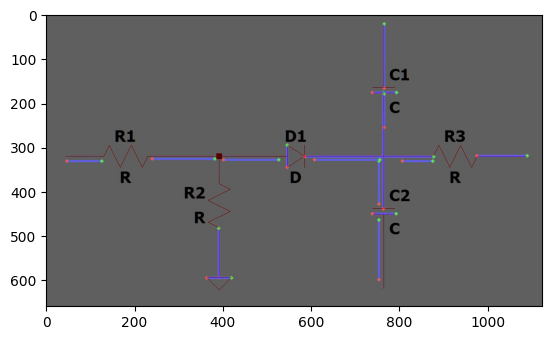

In [10]:

path = os.path.join(os.getcwd(), "output/randomSubFolder")
filelist = [ f for f in os.listdir(path) if f.endswith(".png") ]
for f in filelist:
    os.remove(os.path.join(path, f))

imgOG = cv2.imread('./tests/images/schematic.JPG')
alpha = 1 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)
imageSliceSize = 140 # The size of the subimages of POI analysis
HLThreshold = 6 # Hough Lines Transform threshold
HLMinLineLength = 50 # Hough Lines Transform minLineLength
HLmaxLineGap = 1 # Hough Lines Transform maxLineGap

img = cv2.convertScaleAbs(imgOG, alpha=alpha, beta=beta)

imgLine = np.zeros(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img, 200, 200, None, 5)
lines = cv2.HoughLinesP(edges, rho = 1, theta = math.pi/2, threshold = HLThreshold, minLineLength = HLMinLineLength , maxLineGap = HLmaxLineGap).squeeze()
np.append(lines,cv2.HoughLinesP(edges, rho = 1, theta = math.pi/2, threshold = HLThreshold-5, minLineLength = HLMinLineLength , maxLineGap = HLmaxLineGap).squeeze())

def saveImageFromPos(img, x, y, winSize, name):
    yMax, xMax, colorChannels = img.shape
    if(x+int(winSize/2) > xMax or y+int(winSize/2) > yMax or x-int(winSize/2) < 0 or y-int(winSize/2) < 0):
        return
    img = img[y-int(winSize/2):y+int(winSize/2), x-int(winSize/2):x+int(winSize/2)]
    filename = 'output/randomSubFolder/' + str(name) +'.png'
    cv2.imwrite(filename, img)

print(lines.shape)
pointDistance = 50

def similairLineInList(list, line):
    for count, l in enumerate(list):
        pt1 = (l[0],l[1])
        pt2 = (l[2],l[3])
        pt3 = (line[0],line[1])
        pt4 = (line[2],line[3])
        if((math.dist(pt1,pt3) < pointDistance and math.dist(pt2,pt4) < pointDistance) or ((math.dist(pt1,pt4) < pointDistance and math.dist(pt2,pt3) < pointDistance))):
            return True
    return False

prunedLinesList = []
prunedLinesList.append(lines[0].tolist())

for count, line in enumerate(lines):
    if(not similairLineInList(prunedLinesList,line)):
        prunedLinesList.append(line.tolist())

prunedLines = np.asarray(prunedLinesList)

for count, line in enumerate(prunedLines):
    pt1 = (line[0],line[1])
    pt2 = (line[2],line[3])
    cv2.line(imgLine, pt1, pt2, (0,0,255), 4)
    cv2.circle(imgLine, pt1, 2, (255,0,0), 3)
    cv2.circle(imgLine, pt2, 2, (0,255,0), 3)
    saveImageFromPos(imgOG.copy(), pt1[0],pt1[1], imageSliceSize, str(count) + 'A')
    saveImageFromPos(imgOG.copy(), pt2[0],pt2[1], imageSliceSize, str(count) + 'B')

print(prunedLines.shape)

fig, ax = plt.subplots()
im2 = ax.imshow(imgLine, vmin=0, vmax=1)
im1 = ax.imshow(img, vmin=0, vmax=1, alpha=0.5)

plt.show()

Found 27 images belonging to 1 classes.
1/1 [==============================] - 5s 5s/step
Found 27 images belonging to 1 classes.


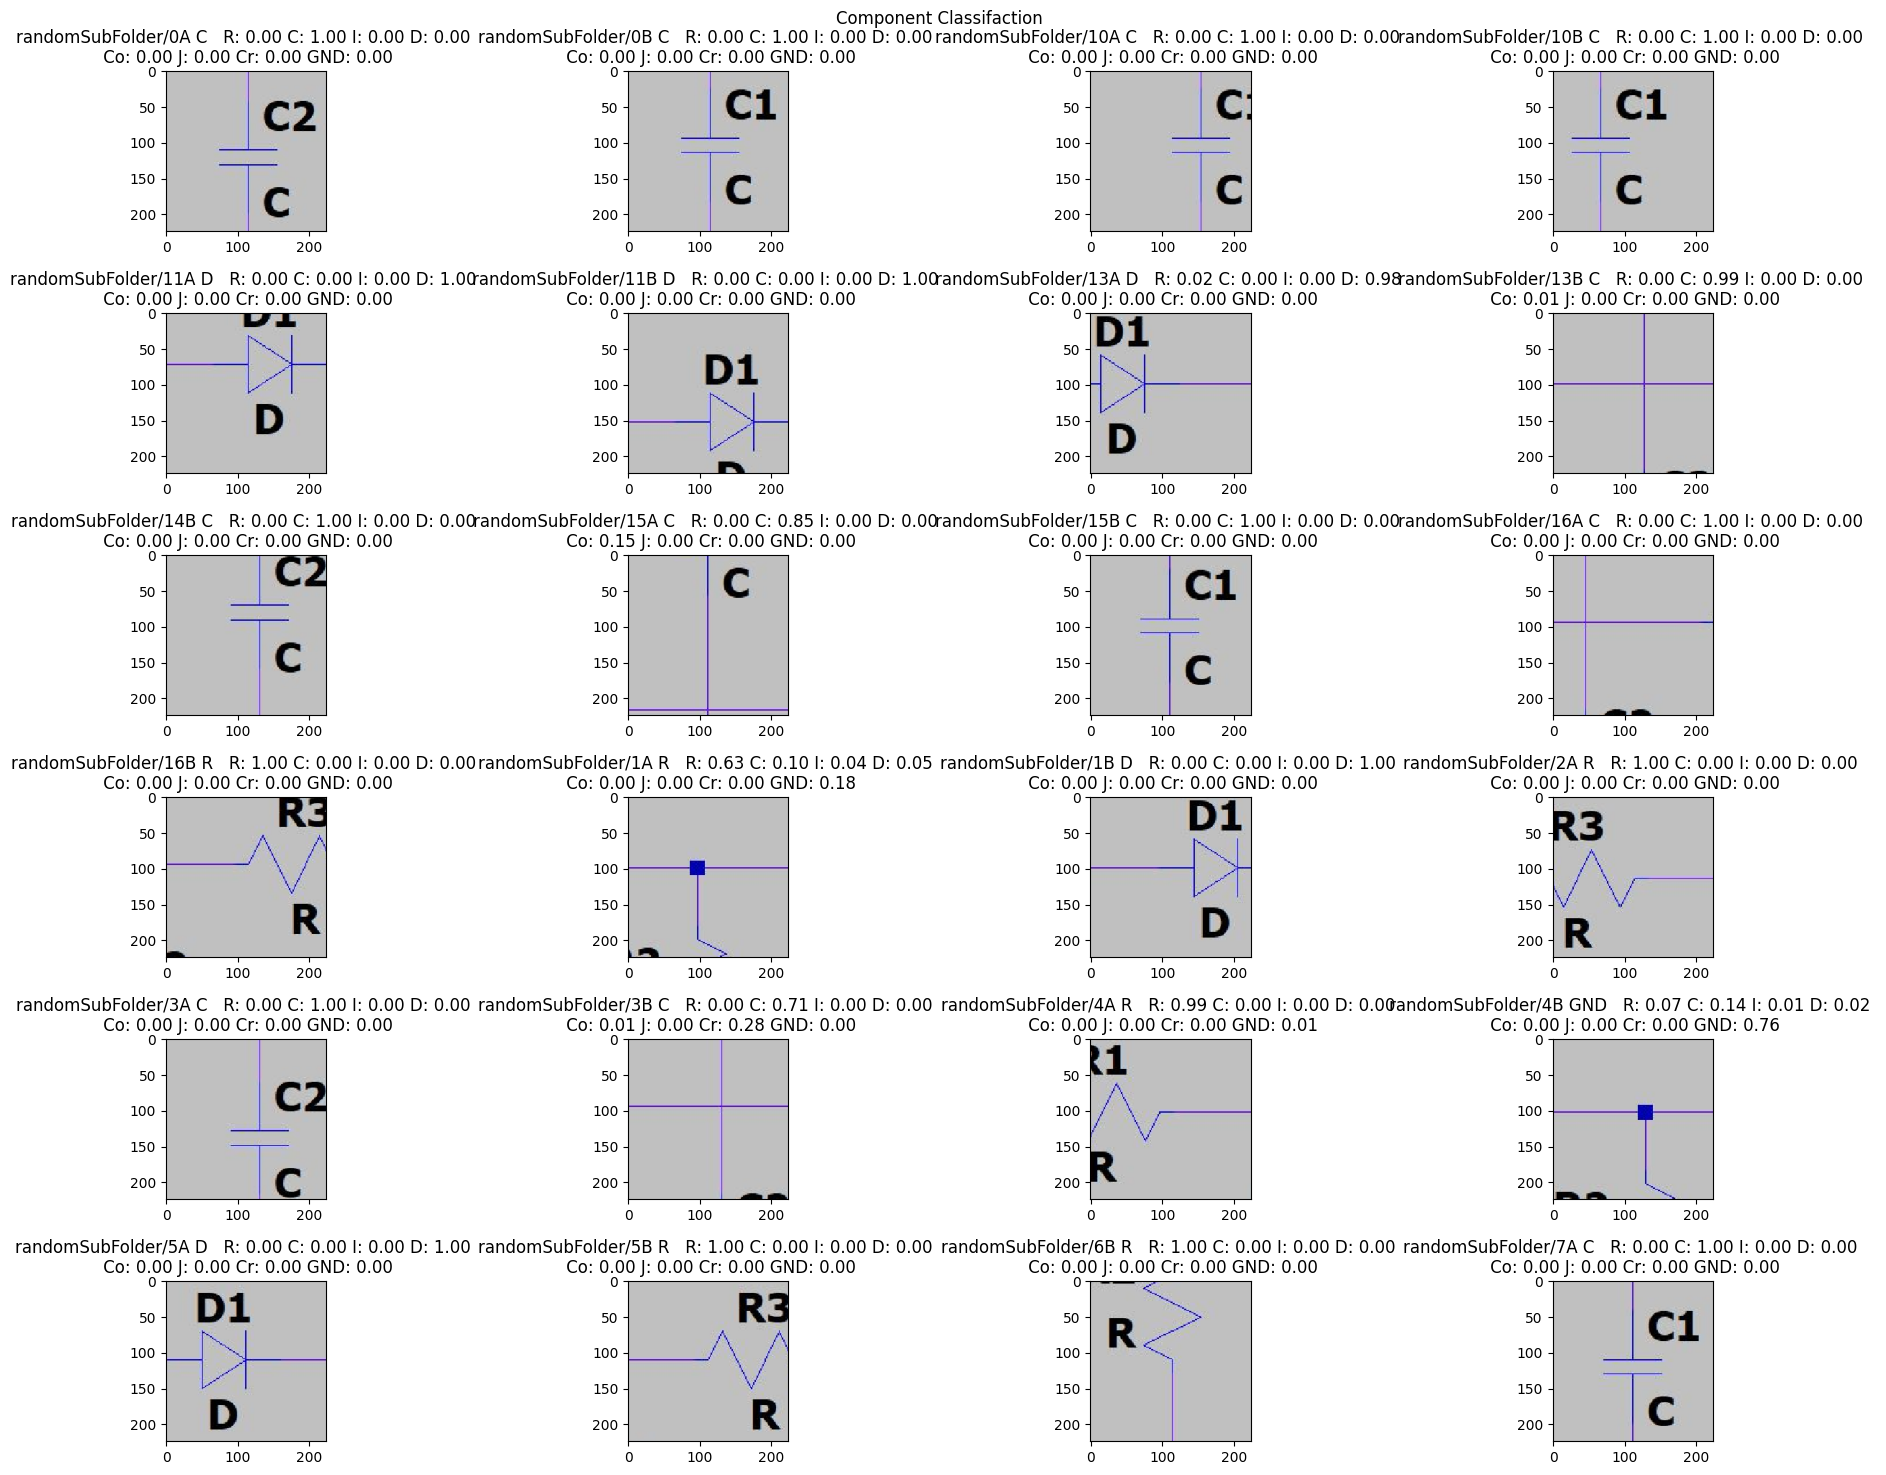

In [11]:
vgg16_model = load_model('SPICEnet/SPICEnet.h5')

image_resize = 224 #WTF IS THIS???

vgg16_prediction = vgg16_model.predict(
    ImageDataGenerator(
        preprocessing_function=preprocess_input,
        ).flow_from_directory(
            'output',
            target_size=(image_resize, image_resize),
            shuffle=False)
)

def getType(arr):
    s = np.argmax(arr)
    return 'R' if (s == 0) else 'C' if (s == 1) else 'I' if (s == 2) else 'D' if (s == 3) else 'Co' if (s == 4) else 'J' if (s == 5) else 'Cr' if (s == 6) else 'GND' if (s == 7) else "PWR"

result_index = ['Capacitor' if (s == 0) else 'Inductor' if (s == 1) else 'Resistance' for s in np.argmax(vgg16_prediction,axis=1)]

my_data_generator = ImageDataGenerator(
    rescale=1./255
)

imageDisplayGenerator = my_data_generator.flow_from_directory(
    'output',
    target_size=(image_resize, image_resize),
    shuffle=False,
    batch_size=100) #THIS IS NE MAX N OF IMAGES TO DISPLAY

fileLabels =  [s.replace('randomSubFolder\\', '').replace('.png', '') for s in imageDisplayGenerator.filenames]

batch_images = imageDisplayGenerator.next()[0]

fig, axs = plt.subplots(nrows=int(imageDisplayGenerator.n/4), ncols=4, figsize=(20, 15)) # define your figure and axes
ind = 0
for ax1 in axs:
    for ax2 in ax1:
        ax2.imshow(batch_images[ind])
        ax2.title.set_text(str(fileLabels[ind]) + " " + getType(vgg16_prediction[ind]) + "   R: %.2f C: %.2f I: %.2f D: %.2f \n Co: %.2f J: %.2f Cr: %.2f GND: %.2f" % (vgg16_prediction[ind][0],vgg16_prediction[ind][1],vgg16_prediction[ind][2],vgg16_prediction[ind][3],vgg16_prediction[ind][4],vgg16_prediction[ind][5],vgg16_prediction[ind][6],vgg16_prediction[ind][7]))
        ind += 1

fig.suptitle('Component Classifaction')
plt.tight_layout()
plt.show()

In [12]:

class POITypes(Enum):
    Resistor = 0
    Capacitor = 1
    Inductor = 2
    Diode = 3
    Corner = 4
    Junction = 5
    Cross = 6
    GND = 7
    PWR = 8

class POI:
   def __init__(self):
      self.type = None
      self.position = None
      self.rotation = None
      self.terminalA = None
      self.terminalB = None
      self.terminalC = None
      self.terminalD = None
      self.value = None
      self.text = None

   def getType(self):
      print("My type is " + str(self.type))

   def getPosition(self):
      print("My position is " + str(self.position))

def isValidPOI(POI):
   return np.argmax(POI) > 0.9

def pred2Type(POI):
   s = np.argmax(POI)
   return POITypes(s)

def isValidPOIInList(list, val):
   try:
      return isValidPOI(list[fileLabels.index(val)])
   except ValueError:
      return False

def findAnchors(anchA, anchB, list):
   for count, line in enumerate(list):
      if(isValidPOIInList(vgg16_prediction, str(count) + "A") and isValidPOIInList(vgg16_prediction, str(count) + "B") and anchorPOIA.type == None):
         ptA = (line[0],line[1]) #A
         ptB = (line[2],line[3]) #B
         anchA.position = ptA
         anchB.position = ptB
         anchA.type = pred2Type(vgg16_prediction[fileLabels.index(str(count) + "A")])
         anchB.type = pred2Type(vgg16_prediction[fileLabels.index(str(count) + "B")])
         anchA.terminalA = anchB
         anchA.value = str(count) + "A"
         anchB.terminalB = anchA
         anchB.value = str(count) + "B"
         print("ANCHOR: " + str(count) + "A " + str(count) + "B")
         return np.delete(list,count,axis=0)

def findClosestLineIndex(lines, point):
   closestLineIndex = 0
   closestLineDistance = 1000000
   EndFlag = 0
   for count, line in enumerate(lines):
      pt1 = (line[0],line[1])
      pt2 = (line[2],line[3])

      if(math.dist(pt1, point) < closestLineDistance and pt1 != point):
         closestLineIndex = count
         closestLineDistance = math.dist(pt1,point)
         EndFlag = 0

      if(math.dist(pt2, point) < closestLineDistance and pt2 != point):
         closestLineIndex = count
         closestLineDistance = math.dist(pt2,point)
         EndFlag = 1
   if(EndFlag):
      return closestLineIndex, EndFlag
   else:
      return closestLineIndex, EndFlag

validLines = prunedLines.copy()

anchorPOIA = POI()
anchorPOIB = POI()

validLines = findAnchors(anchorPOIA, anchorPOIB, validLines)# FIND ANCHORS AND REMOVE THEM FROM LIST

anchorPOIA.getType()
anchorPOIB.getType()

#traverse down anchorPOIA.terminalB
#find closest point to anchorPOIA.terminalB


print(prunedLines[findClosestLineIndex(validLines, anchorPOIA.position)])
anchorPOIA.getPosition()
#traverse down anchorPOIB.terminalA

closestIndex, whichEnd = findClosestLineIndex(validLines, anchorPOIA.position)
print(validLines[closestIndex])
print(whichEnd)

POIC = POI()

if(whichEnd):
   pt = (line[2],line[3])
   POIC.position = pt
   POIC.type = pred2Type(vgg16_prediction[fileLabels.index(str(closestIndex) + "B")])
   POIC.value = str(closestIndex) + "B"
else:
   pt = (line[0],line[1])
   POIC.position = pt
   POIC.type = pred2Type(vgg16_prediction[fileLabels.index(str(closestIndex) + "A")])
   POIC.value = str(closestIndex) + "A"

anchorPOIB.terminalA = POIC

POIC.getType()
print(POIC.value)

#CUS POIC IS A CROSS 4 terminals that we need to traverse down
def TraverseDownOnPOI(poi):
   if(poi.terminalA == None):
      print()
      #FIND SHIT
   if(poi.terminalB == None):
      print()
      #FIND SHIT
   if((poi.type == POITypes.Junction or poi.type == POITypes.Cross) and poi.terminalC == None):
      print()
      #FIND SHIT
   if(poi.type == POITypes.Cross and poi.terminalD == None):
      print()
      #FIND SHIT


#line[x] has the files xA.png and xB.png associated with the two end terminals

#We need to star building up a graph!

#Step 1: Find and anchor | iterate over line till we find one with two valid components at the ends

#Step 2: Find closest differnt line beginning for anchorAComponent Terminal B
#Identify component at the other end of line, and iterate/branch
# Do the same for anchorBComponent Terminal B

#if a line has no two valid components at the end, remove it from dataSet

#We should have a full tree now

My type is None
My type is None


TypeError: 'NoneType' object is not iterable

In [13]:
dir = os.listdir(os.getcwd())
if("output.asc" in dir):
    os.remove(os.path.join(os.getcwd(), "output.asc"))

f = open("output.asc", "w")

f.write("SHEET 1 880 680\n")
f.write("WIRE 240 160 128 160\n")

f.close()

##TYPICAL OUTPUT CODE FOR LTSPICE
#SHEET 1 880 680

#WIRE 240 160 128 160 #XSTart- YStart - XEnd - YEnd
#SYMBOL res 144 144 R90 # X - Y - Rotation
#WINDOW 0 0 56 VBottom 2
#WINDOW 3 32 56 VTop 2
#SYMATTR InstName R1 #Name the thing

#SYMBOL cap 304 144 R90
#WINDOW 0 0 32 VBottom 2
#WINDOW 3 32 32 VTop 2
#SYMATTR InstName C1
